In [ ]:
'''
try:
    pagination_next_element = content.find("a", attrs={"data-testid": "pagination-next"})
    number_of_pages_string = pagination_next_element.get("aria-label")
    number_of_pages = re.findall(r"\d+", number_of_pages_string)[-1]
except AttributeError:
    print("No results found or couldn't determine number of pages.")
    continue
except Exception as e:
    print(f"An error occurred while determining number of pages: {e}")
    continue  

print(f"There are {number_of_pages} pages in total.")

'''

### imports

In [ ]:
import os
import re
import time
import datetime
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver  
from selenium.webdriver.common.keys import Keys  
from selenium.webdriver.chrome.options import Options

import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

### criteria

In [56]:
#POSTCODE IS COMPULSORY

criteria = {
    "postcode": "UB10 0EQ",
    "radius": "300",
    "year_from": "2005",
    "year_to": "2015",
    "price_from": "3000",
    "price_to": "10000",
}

criteria2 = {
    "postcode": "CV31 3QR", 
    "radius": "200",
    "year_from": "1995",
    "year_to": "2013",
    "price_from": "1000",
    "price_to": "40000",
}

accord = [
    {
         "make": "Honda",
         "model": "Accord"
    },

]

cars = [
     {
         "make": "Vauxhall",
         "model": "Corsa"
    },

     {
         "make": "Toyota",
         "model": "Yaris"
    },

     {
         "make": "Honda",
         "model": "Civic"
    }
]

cars2 = [
    {
         "make": "Mazda",
         "model": "MX-5"
    },

    {
         "make": "BMW",
         "model": "Z4"
    },

    {
         "make": "Toyota",
         "model": "Celica"
    },

    {
         "make": "Toyota",
         "model": "GT86"
    }
]


### functions

In [52]:

def scrape_autotrader(cars, criteria):
    chrome_options = Options()
    chrome_options.add_argument("_tt_enable_cookie=1")
    driver = webdriver.Chrome()
    data = []

    for car in cars:

        # Example URL: 
        # https://www.autotrader.co.uk/car-search?advertising-location=at_cars&include-delivery-option=on&make=Honda&model=Jazz&postcode=LS12AD&radius=10&sort=relevance&year-from=2011&year-to=2015
        
        params = []

        if car.get('make'):
            params.append(f"make={car['make']}")
        if car.get('model'):
            params.append(f"model={car['model']}")
        if criteria.get('postcode'):    
            params.append(f"postcode={criteria['postcode']}") 
        if criteria.get('radius'):    
            params.append(f"radius={criteria['radius']}")
        
        params.append("sort=relevance")
        if criteria.get('year_from'):
            params.append(f"year-from={criteria['year_from']}")
        if criteria.get('year_to'):
            params.append(f"year-to={criteria['year_to']}")
        if criteria.get('price_from'):
            params.append(f"price-from={criteria['price_from']}")
        if criteria.get('price_to'):
            params.append(f"price-to={criteria['price_to']}")
        
        
        url = "https://www.autotrader.co.uk/car-search?advertising-location=at_cars&include-delivery-option=on" + '&'.join(params)
        
        print(url)

        driver.get(url)

        time.sleep(5) 

        source = driver.page_source
        content = BeautifulSoup(source, "html.parser")

        number_of_pages = 0

        try:
            results = content.find("span", attrs={"data-testid": "search-result-count"})
            number_of_articles = results.text.split()[0].replace(",","")
            number_of_pages = int(number_of_articles) // 19 # Approximate, overestimated to maximise results

            if number_of_pages == 0:
                number_of_pages = 1

        except AttributeError:
            print("No results found or couldn't determine number of pages.")
            continue
        except Exception as e:
            print(f"An error occurred while determining number of pages: {e}")
            continue  

        print(f"There are {number_of_pages} pages in total.")
        
        for i in range(int(number_of_pages)):
            driver.get(url + f"&page={str(i + 1)}")
            
            time.sleep(5)
            page_source = driver.page_source
            content = BeautifulSoup(page_source, "html.parser")

            articles = content.findAll("div", attrs={"data-testid": "advertCard"})

            for article in articles:
                details = {
                    "name": None,
                    "price": None,
                    "year": None,
                    "mileage": None,
                    "transmission": None,
                    "fuel": None,
                    "engine": None,
                    "owners": None,
                    "location": None,
                    "distance": None,
                    "link": None
                }

                # Name
                if car.get('make'):
                    details['name'] = car['make'] 
                    if car.get('model'):
                        details['name'] += " " + car['model']
                
                # Price
                price_match = re.search(r"[£]\d+(,\d{3})?", article.text)
                if price_match:
                    details["price"] = price_match.group(0)

                # Link
                link_tag = article.find("a", href=re.compile(r"/car-details/"))
                if link_tag and link_tag.has_attr("href"):
                    details["link"] = link_tag["href"]

                # Location & distance
                try:
                    seller_info = article.find("span", attrs={"data-testid": "search-listing-location"}).text
                    location = seller_info.split("Dealer location")[1]
                    details["location"] = location.split("(")[0].strip()
                    details["distance"] = location.split("(")[1].replace(" mile)", "").replace(" miles)", "").strip()
                except Exception:
                    pass  # location info missing

                # Specs
                specs_list = article.find("ul", attrs={"data-testid": "badges-container"})
                if specs_list:
                    for spec in specs_list.find_all("li"):
                        text = spec.get_text(strip=True)

                        if "reg" in text:
                            details["year"] = text

                        if "miles" in text:
                            details["mileage"] = text

                        if text in ["Manual", "Automatic"]:
                            details["transmission"] = text

                        if "." in text and "L" in text:
                            details["engine"] = text

                        if text in ["Petrol", "Diesel"]:
                            details["fuel"] = text

                        if "owner" in text:
                            details["owners"] = text[0]

                data.append(details)


            print(f"Page {str(i + 1)} scraped. ({len(articles)} articles)")
            time.sleep(5)

        print("\n\n")

    print(f"{len(data)} cars total found.")

    return data


In [53]:
def output_data(data, criteria, name='cars'):
    df = pd.DataFrame(data)

    df["price"] = df["price"].str.replace("£", "").str.replace(",", "")
    df["price"] = pd.to_numeric(df["price"], errors="coerce").astype("Int64")

    df["year"] = df["year"].str.replace(r"\s(\(\d\d reg\))", "", regex=True)
    df["year"] = pd.to_numeric(df["year"], errors="coerce").astype("Int64")

    df["mileage"] = df["mileage"].str.replace(",", "").str.replace(" miles", "")
    df["mileage"] = pd.to_numeric(df["mileage"], errors="coerce").astype("Int64")

    now = datetime.datetime.now()
    df["miles_pa"] = df["mileage"] / (now.year - df["year"])
    df.fillna({'miles_pa': 0},inplace=True)
    df["miles_pa"] = df["miles_pa"].astype(int)

    df["owners"] = df["owners"].fillna("-1") 
    df["owners"] = df["owners"].astype(int)

    df["distance"] = df["distance"].fillna("-1") 
    df["distance"] = df["distance"].astype(int)

    df["link"] = "https://www.autotrader.co.uk" + df["link"] 

    df = df[[
        "name",
        "link",
        "price",
        "year",
        "mileage",
        "miles_pa",
        "owners",
        "distance",
        "location",
        "engine",
        "transmission",
        "fuel",
    ]]

    df = df[df["price"] < int(criteria["price_to"])]

    df = df.sort_values(by="distance", ascending=True)

    df.to_csv(name)

    return df

### workspace

In [57]:
data = scrape_autotrader(accord, criteria2)

https://www.autotrader.co.uk/car-search?advertising-location=at_cars&include-delivery-option=onmake=Honda&model=Accord&postcode=CV31 3QR&radius=200&sort=relevance&year-from=1995&year-to=2013&price-from=1000&price-to=40000
There are 6 pages in total.
Page 1 scraped. (21 articles)
Page 2 scraped. (22 articles)
Page 3 scraped. (22 articles)
Page 4 scraped. (22 articles)
Page 5 scraped. (22 articles)
Page 6 scraped. (17 articles)



126 cars total found.


In [58]:
df = output_data(data, criteria2, name='Accord Test')

<Axes: xlabel='mileage', ylabel='price'>

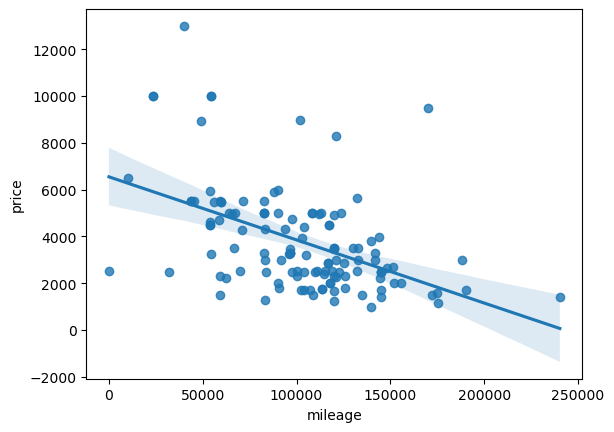

In [59]:
sns.regplot(data=df, x='mileage',y='price')